In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#train_data = pd.read_csv('/content/drive/MyDrive/metin_madenciligi_proje/preprocessed_european_comments_train.csv')
#train_data_new = train_data[train_data['body'].notnull()]

#test_data = pd.read_csv("/content/drive/MyDrive/metin_madenciligi_proje/preprocessed_european_comments_test.csv")
#test_data_new = test_data[test_data['body'].notnull()]

data = pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2016/preprocessed_twitter_2016.csv')

In [4]:
data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,rt _hockey: it’s gold gbr rio2016 hockey @_gbh…,0.000,0.000,Neutral
1,1,amazing! congratulations winning modernpentath...,0.825,0.625,Positive
2,2,wait. ashton eaton won decathlon gold again? yas!,0.000,0.000,Neutral
3,3,got shivers watching end chloe esposito's race...,0.000,0.000,Neutral
4,4,celebrating gold! effort! congratulations! 👍💪🏅,0.000,0.000,Neutral


In [5]:
#combined_data = train_data.append(test_data, ignore_index=True)
data.shape

(82736, 5)

In [6]:
data["Analysis"].value_counts()

Neutral     48303
Positive    24413
Negative    10020
Name: Analysis, dtype: int64

In [7]:
tokenized_data = data['tweet'].apply(lambda x: str(x).split()) # tokenizing

In [8]:
tokenized_data

0        [rt, _hockey:, it’s, gold, gbr, rio2016, hocke...
1        [amazing!, congratulations, winning, modernpen...
2        [wait., ashton, eaton, won, decathlon, gold, a...
3        [got, shivers, watching, end, chloe, esposito'...
4        [celebrating, gold!, effort!, congratulations!...
                               ...                        
82731    [closed, buy, xauusd, 1351.54, -653.0, pips,, ...
82732    [closed, buy, 67.0, lots, xauusd, 1351.54, -65...
82733    [closed, buy, xauusd, 1351.54, -653.0, pips,, ...
82734    [august, 2016, far, 45.97%, robot, ea, realacc...
82735    [xauusd, uluslararası, piyasa, raporu, yayınla...
Name: tweet, Length: 82736, dtype: object

In [9]:
from gensim.models import Word2Vec

In [10]:
model_w2v = Word2Vec(tokenized_data, size=256,  window=5)
model_w2v.train(tokenized_data, total_examples= len(tokenized_data), epochs=10)

(7531645, 8095400)

In [11]:
model_w2v.wv.most_similar(positive="gold")

[('gymnastics', 0.4244753122329712),
 ('$gdx', 0.41428443789482117),
 ('$gld', 0.4102936089038849),
 ('$tlt', 0.4011358916759491),
 ('brexit,ordinary', 0.4000675678253174),
 ('$gdxj', 0.39875274896621704),
 ('gold.', 0.38347238302230835),
 ('shares', 0.3781079947948456),
 ('commodities', 0.35599303245544434),
 ('analyst:', 0.3551419973373413)]

In [12]:
# EEZ: Exclusive Economic Zone (Münhasır Ekonomik Bölge)
model_w2v.wv.most_similar(positive="exchange")

[('alwaysbusyselling', 0.571086049079895),
 ('urmston', 0.5579078793525696),
 ('yangon', 0.5365380048751831),
 ('clutter', 0.5315607190132141),
 ("myanmar's", 0.5165743827819824),
 ('summary', 0.48927050828933716),
 ('nikkei225', 0.48652184009552),
 ('valle', 0.48272234201431274),
 ('replace', 0.4715310335159302),
 ('calculates', 0.4560515880584717)]

In [13]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [14]:
wordvec_arrays = np.zeros((len(tokenized_data), 256))

for i in range(len(data)):
    wordvec_arrays[i,:] = word_vector(tokenized_data[i], 256)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

<ipython-input-13-2f6882f45f7b>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += model_w2v[word].reshape((1, size))


(82736, 256)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
#train_w2v = wordvec_df.iloc[:56819,:]
#test_w2v = wordvec_df.iloc[56819:,:]

X_train, x_test, y_train, y_valid = train_test_split(wordvec_df, data['Analysis'],  
                                                          random_state=42, 
                                                          test_size=0.2)

#print(train_w2v.shape, data['Analysis'].shape)

#xtrain_w2v = train_w2v.iloc[y_train.index,:]
#xvalid_w2v = train_w2v.iloc[y_valid.index,:]

In [17]:
X_train.shape

(66188, 256)

In [18]:
x_test.shape

(16548, 256)

In [19]:
y_train.shape

(66188,)

In [20]:
y_train

55067    Positive
49269     Neutral
4850      Neutral
66799    Positive
27556     Neutral
           ...   
6265     Positive
54886    Positive
76820    Positive
860       Neutral
15795     Neutral
Name: Analysis, Length: 66188, dtype: object

In [21]:
y_valid.shape

(16548,)

In [22]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_valid)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [23]:
train_labels

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [24]:
test_labels.shape

(16548, 3)

In [25]:
import tensorflow as tf
import keras.layers as layers
from keras.models import Model
from keras import models
import keras.losses

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Embedding,Dense,Flatten
from tensorflow.keras.metrics import AUC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

epochs = 50
batch_size = 256
optimizer = "adam"
metrics = ["categorical_crossentropy", AUC(name='auc')]

# Build neural network
model = models.Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics= metrics)

history = model.fit(X_train, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(x_test, test_labels))

Epoch 1/50
259/259 [==============================] - 4s 6ms/step - loss: 0.5348 - categorical_crossentropy: 0.5348 - auc: 0.9258 - val_loss: 0.2976 - val_categorical_crossentropy: 0.2976 - val_auc: 0.9772
Epoch 2/50
259/259 [==============================] - 1s 4ms/step - loss: 0.2368 - categorical_crossentropy: 0.2368 - auc: 0.9846 - val_loss: 0.1914 - val_categorical_crossentropy: 0.1914 - val_auc: 0.9892
Epoch 3/50
259/259 [==============================] - 1s 5ms/step - loss: 0.1634 - categorical_crossentropy: 0.1634 - auc: 0.9918 - val_loss: 0.1526 - val_categorical_crossentropy: 0.1526 - val_auc: 0.9923
Epoch 4/50
259/259 [==============================] - 1s 5ms/step - loss: 0.1288 - categorical_crossentropy: 0.1288 - auc: 0.9945 - val_loss: 0.1264 - val_categorical_crossentropy: 0.1264 - val_auc: 0.9940
Epoch 5/50
259/259 [==============================] - 1s 5ms/step - loss: 0.1083 - categorical_crossentropy: 0.1083 - auc: 0.9958 - val_loss: 0.1173 - val_categorical_crossentr

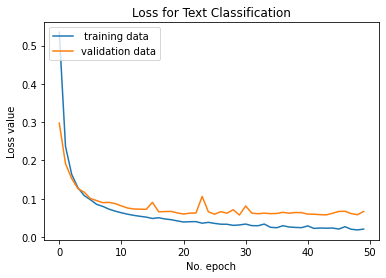

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

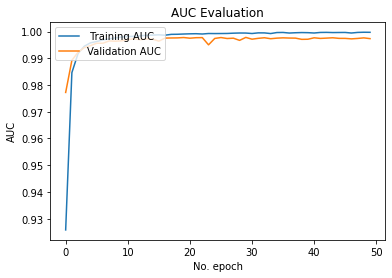

In [27]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [28]:
y__pred = model.predict(x_test)


518/518 [==============================] - 1s 1ms/step


In [29]:
y__pred.shape

(16548, 3)

In [30]:
y__pred = np.where((y__pred == 0),'Negative', y__pred)
y__pred = np.where((y__pred == '1'),'Neutral', y__pred)
y__pred = np.where((y__pred == '2'),'Positive', y__pred)

In [31]:
y_valid.shape

(16548,)

In [32]:
print(classification_report(data.Analysis, y__pred))

ValueError: ignored